In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math as mt
import warnings

# 한글출력
matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action='ignore') 

from src import crs, PublicPredictor

In [3]:
# 1. load_excel
data_path = "data/apt_1.xlsx"
xlsx = pd.read_excel(data_path, header=None,
                     skiprows=2, engine="openpyxl")

# 2. data preprocessing
p, m = crs.utils.data_preprocessing(xlsx)

m.set_index("month", inplace=True)

# 3. data init
_month = 1

month_df = pd.DataFrame(m.loc[_month])
month_df.reset_index(inplace=True)

month_df.columns = ['name', 'usage (kWh)']

PUBLIC_PERCENTAGE = 30
APT = crs.utils.get_APT(month_df, PUBLIC_PERCENTAGE)

calc = crs.models.ManagementOffice(
        month=_month,
        households=month_df,
        APT=APT,
        contract="단일계약"
    )
apt = calc.apart

In [6]:
fee = calc.fee
public_bill = calc.public_bill
public_bill

2640560

In [7]:
_public_bill = public_bill / len(month_df)
_public_bill

24449.62962962963

# 기존 수거부담율 현황

In [11]:
basic_col_burden = list()
basic_col = list()
now_apt_step = 0
APT_mean = round(APT / len(month_df))

for step,_ in enumerate(fee):
    if APT_mean < _[1]:
        now_apt_step = step
        break
        
for usage in month_df['usage (kWh)']:    
    _basic = 0
    for _ in fee:
        if usage < _[1]:
            _basic = _[2]
            basic_col_burden.append(fee[now_apt_step][2] / _basic)
            basic_col.append(_basic)
            break

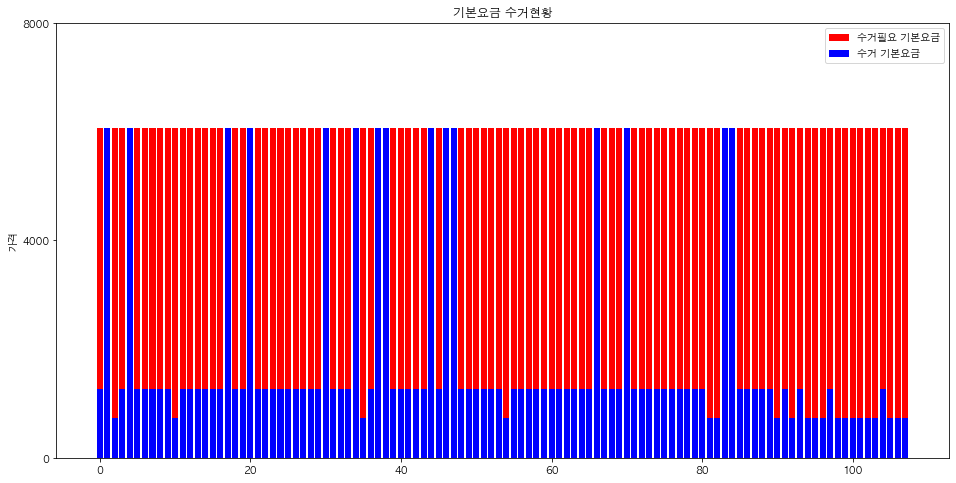

In [12]:
plt.figure(figsize=(16,8))

plt.bar(range(len(month_df)),fee[now_apt_step][2], label='수거필요 기본요금', color='r')
plt.bar(range(len(month_df)),basic_col, label='수거 기본요금', color='b')

plt.title("기본요금 수거현황")
plt.legend()
plt.yticks([0, 4000, 8000])
plt.ylabel("가격")

plt.show()

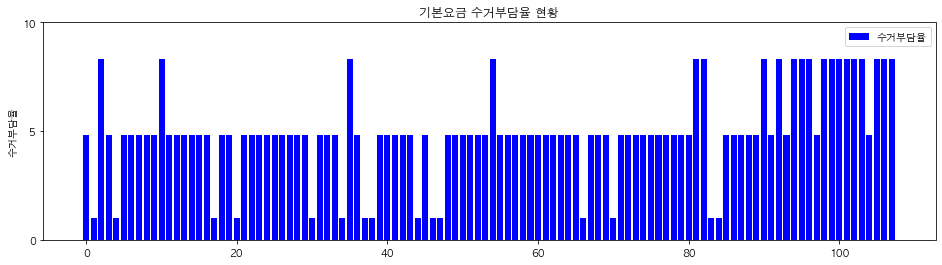

In [17]:
plt.figure(figsize=(16,4))

plt.bar(range(len(month_df)),basic_col_burden, label='수거부담율', color='b')
plt.title("기본요금 수거부담율 현황")
plt.legend()
plt.yticks([0, 5, 10])
plt.ylabel("수거부담율")

plt.show()

In [18]:
def get_col_list(kWh, fee):
    col_list = list()
    _usage = kWh
    for step, _f in enumerate(fee):
        collect_rate = _f[1] - _f[0]

        # 2단계일 경우
        if step == 1:
            collect_rate += 1

        if kWh < _f[1]:
            if (step == 0) or (step == 1):
                _col = _usage % collect_rate
            else:
                _col = _usage
        else:
            _col = collect_rate

        if _usage == 0:
            col_list.append(0)
        else:
            col_list.append(_col)
            _usage -= _col

    return np.array(col_list)

def get_step_mem(col_list, fee):
    _mem = list()
    _mem_step = 0
    
    for step,val in enumerate(col_list):
        _val = val
        f = fee[step][3]
        
        while _val != 0:
            _mem_step += f
            _mem.append(_mem_step)
            _val -= 1
            
            
    return np.array(_mem)

In [19]:
households_mean = round(month_df['usage (kWh)'].mean())
APT_mean = round(APT / len(month_df))

households_col = get_col_list(households_mean, fee)
APT_col = get_col_list(APT_mean, fee)
public_col = APT_col - households_col
public_mem = get_step_mem(public_col, fee)
col_burden_list = list()

for usage in month_df['usage (kWh)']:
    chk_households_col = get_col_list(usage, fee)
    _APT_mean = usage + public_col.sum()

    chk_APT_col = get_col_list(_APT_mean, fee)
    chk_public_col = chk_APT_col - chk_households_col
    chk_public_mem = get_step_mem(chk_public_col, fee)
    col_burden = public_mem / chk_public_mem
    
    col_burden_list.append(col_burden[-1])

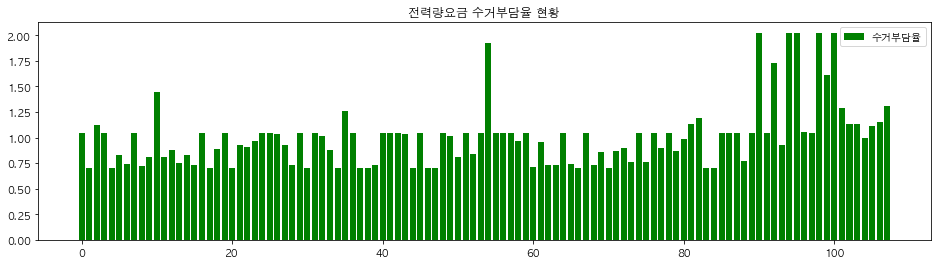

In [21]:
plt.figure(figsize=(16,4))

plt.bar(range(len(col_burden_list)), col_burden_list, color='g', label='수거부담율')
plt.title("전력량요금 수거부담율 현황")

plt.legend()

plt.show()

# 가격분배 후 수거부담율 현황

## 히스토그램 그룹화

<AxesSubplot:>

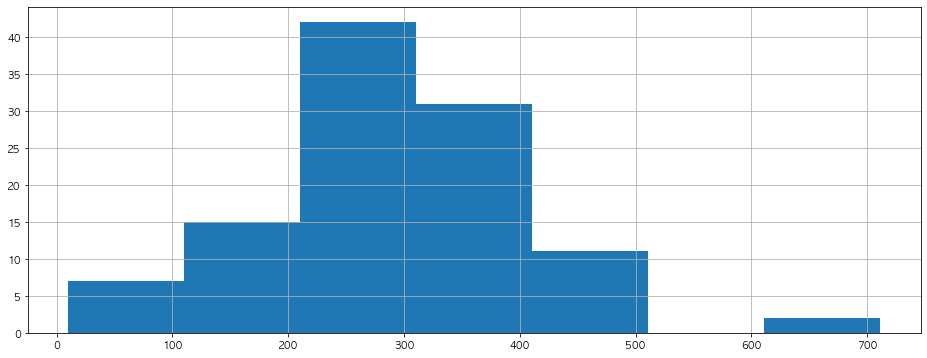

In [22]:
bins = round(mt.sqrt(len(month_df) / 2))

month_df['usage (kWh)'].hist(bins=bins, figsize=(16,6))

## 그룹화 방식 : 그룹의 중간값과 그룹의 중간값 토탈과 비교하여 기여도 산정, 가격분배 방식 : 기여도 공용부요금 일 때의 기본요금 수거부담율과 전력량요금 수거부담율 형태

In [27]:
y, x = np.histogram(month_df['usage (kWh)'].values, bins=bins)
hist_df = pd.DataFrame(columns=['start', 'end', '가구 수'])

for idx, _x in enumerate(x[:-1]):
    _y = y[idx]
    
    start = _x
    end = x[idx + 1]
    
    hist_df = hist_df.append({
        "start": start,
        "end": end,
        "가구 수": _y
    }, ignore_index=True)
    
groups = np.array([])

for usage in month_df['usage (kWh)']:
    chk = []
    
    for idx, row in hist_df.iterrows():
        start = row['start']
        end = row['end']
        
        chk.append((usage >= start) and (usage <= end))

    group_num = np.where(chk)[0][0]
    groups = np.append(groups, group_num).astype("int")
    
month_df['그룹 번호'] = groups
# month_df.head(10)

medians = []

for idx, row in hist_df.iterrows():
    start = row['start']
    end = row['end']
    
    medians.append((start + end) / 2)
    
hist_df['median'] = medians
hist_df_1_1 = hist_df.copy()

median_total = hist_df['median'].sum()
hist_df_1_1['contribution'] = hist_df_1_1['median'] / median_total
hist_df_1_1

,start,end,가구 수,median,contribution
0,10.000000,110.142857,7.0,60.071429,0.023805
1,110.142857,210.285714,15.0,160.214286,0.063489
2,210.285714,310.428571,42.0,260.357143,0.103173
3,310.428571,410.571429,31.0,360.500000,0.142857
4,410.571429,510.714286,11.0,460.642857,0.182541
5,510.714286,610.857143,0.0,560.785714,0.222225
6,610.857143,711.000000,2.0,660.928571,0.261909


In [28]:
# 예측 시뮬레이션
pp = PublicPredictor(
    APT=APT,
    month_df=month_df[['name', 'usage (kWh)']],
    month=_month
)
pp.predict

실제 요금    2640560
예측 요금    2639700
오차           860
dtype: int64

In [29]:
col_df = hist_df

col_df['공용부 기본요금'] = (round(pp.basic / len(month_df)) * col_df['가구 수']).round().astype("int")
col_df['공용부 전력량요금'] = round(pp.elec_rate / len(month_df)) * col_df['가구 수'].round().astype("int")

col_df

,start,end,가구 수,median,공용부 기본요금,공용부 전력량요금
0,10.000000,110.142857,7.0,60.071429,29764,116158
1,110.142857,210.285714,15.0,160.214286,63780,248910
2,210.285714,310.428571,42.0,260.357143,178584,696948
3,310.428571,410.571429,31.0,360.500000,131812,514414
4,410.571429,510.714286,11.0,460.642857,46772,182534
5,510.714286,610.857143,0.0,560.785714,0,0
6,610.857143,711.000000,2.0,660.928571,8504,33188


In [30]:
dist_1_1 = hist_df_1_1.copy()
dist_1_1 = pd.concat([dist_1_1, col_df[col_df.columns[-2:]]], axis=1)
dist_1_1 = dist_1_1[dist_1_1['가구 수'] > 0]

dist_1_1['기여도 공용부 기본요금'] = (dist_1_1['공용부 기본요금'] * dist_1_1['contribution']).round().astype("int")
dist_1_1['기여도 공용부 전력량요금'] = (dist_1_1['공용부 전력량요금'] * dist_1_1['contribution']).round().astype("int")
dist_1_1['기여도 공용부 요금'] = dist_1_1['기여도 공용부 기본요금'] + dist_1_1['기여도 공용부 전력량요금']
dist_1_1['가구 별 분배가격'] = (dist_1_1['기여도 공용부 요금'] / dist_1_1['가구 수']).round().astype("int")

dist_1_1

,start,end,가구 수,median,contribution,공용부 기본요금,공용부 전력량요금,기여도 공용부 기본요금,기여도 공용부 전력량요금,기여도 공용부 요금,가구 별 분배가격
0,10.000000,110.142857,7.0,60.071429,0.023805,29764,116158,709,2765,3474,496
1,110.142857,210.285714,15.0,160.214286,0.063489,63780,248910,4049,15803,19852,1323
2,210.285714,310.428571,42.0,260.357143,0.103173,178584,696948,18425,71906,90331,2151
3,310.428571,410.571429,31.0,360.500000,0.142857,131812,514414,18830,73488,92318,2978
4,410.571429,510.714286,11.0,460.642857,0.182541,46772,182534,8538,33320,41858,3805
6,610.857143,711.000000,2.0,660.928571,0.261909,8504,33188,2227,8692,10919,5460


In [36]:
per_basic = round(pp.basic / len(month_df))
per_elec_rate = round(pp.elec_rate / len(month_df))

In [38]:
dist_cont_1_1 = month_df.copy()

dist_cont_1_1['공용부 기본요금'] = dist_cont_1_1['그룹 번호'].map(
    lambda x: round(dist_1_1.loc[x]['기여도 공용부 기본요금'] / dist_1_1.loc[x]['가구 수'])
)
dist_cont_1_1['공용부 전력량요금'] = dist_cont_1_1['그룹 번호'].map(
    lambda x: round(dist_1_1.loc[x]['기여도 공용부 전력량요금'] / dist_1_1.loc[x]['가구 수'])
)
    
dist_cont_1_1.head(10)

,name,usage (kWh),그룹 번호,공용부 기본요금,공용부 전력량요금
0,아파트1-101-1002,253,2,439,1712
1,아파트1-101-104,689,6,1114,4346
2,아파트1-101-1102,183,1,270,1054
3,아파트1-101-1202,239,2,439,1712
4,아파트1-101-1302,455,4,776,3029
5,아파트1-101-1401,343,3,607,2371
6,아파트1-101-1403,380,3,607,2371
7,아파트1-101-1502,219,2,439,1712
8,아파트1-101-1504,389,3,607,2371
9,아파트1-101-1602,350,3,607,2371


## 기본요금 수거부담율 확인

In [52]:
basic_col_burden = list()
basic_col = list()
now_apt_step = 0
APT_mean = round(APT / len(month_df))

for step,_ in enumerate(fee):
    if APT_mean < _[1]:
        now_apt_step = step
        break
        
for idx, row in dist_cont_1_1.iterrows():    
    usage = row['usage (kWh)']
    public_sale = row['공용부 기본요금']
    _basic = per_basic - public_sale
    for _ in fee:
        if usage < _[1]:
            _basic += _[2]
            basic_col_burden.append(fee[now_apt_step][2] / _basic)
            basic_col.append(_basic)
            break

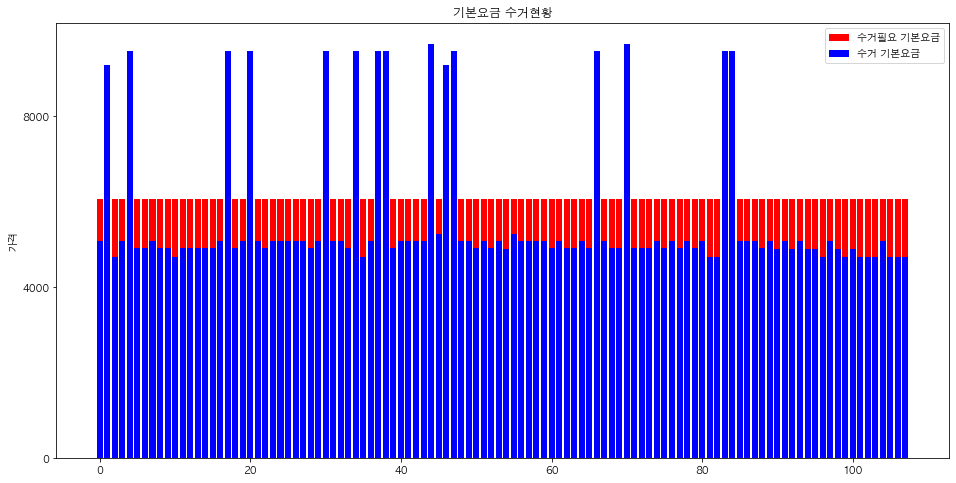

In [53]:
plt.figure(figsize=(16,8))

plt.bar(range(len(month_df)),fee[now_apt_step][2], label='수거필요 기본요금', color='r')
plt.bar(range(len(month_df)),basic_col, label='수거 기본요금', color='b')

plt.title("기본요금 수거현황")
plt.legend()
plt.yticks([0, 4000, 8000])
plt.ylabel("가격")

plt.show()

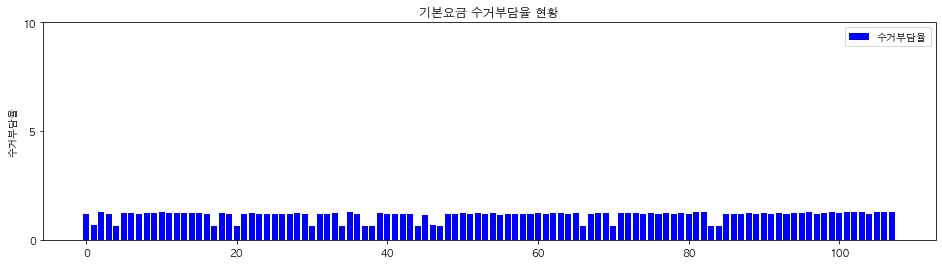

In [54]:
plt.figure(figsize=(16,4))

plt.bar(range(len(month_df)),basic_col_burden, label='수거부담율', color='b')
plt.title("기본요금 수거부담율 현황")
plt.legend()
plt.yticks([0, 5, 10])
plt.ylabel("수거부담율")

plt.show()

## 전력량요금 수거부담율

In [55]:
households_mean = round(month_df['usage (kWh)'].mean())
APT_mean = round(APT / len(month_df))

households_col = get_col_list(households_mean, fee)
APT_col = get_col_list(APT_mean, fee)
public_col = APT_col - households_col
public_mem = get_step_mem(public_col, fee)
col_burden_list = list()

for idx, row in dist_cont_1_1.iterrows():    
    usage = row['usage (kWh)']
    public_sale = row['공용부 전력량요금']
    _elec_rate = per_elec_rate - public_sale
    
    chk_households_col = get_col_list(usage, fee)
    _APT_mean = usage + public_col.sum()

    chk_APT_col = get_col_list(_APT_mean, fee)
    chk_public_col = chk_APT_col - chk_households_col
    chk_public_mem = get_step_mem(chk_public_col, fee)
    
    my_er = chk_public_mem[-1] + _elec_rate
    public_er = public_mem[-1]
    
    col_burden = public_er / my_er
    
    col_burden_list.append(col_burden)

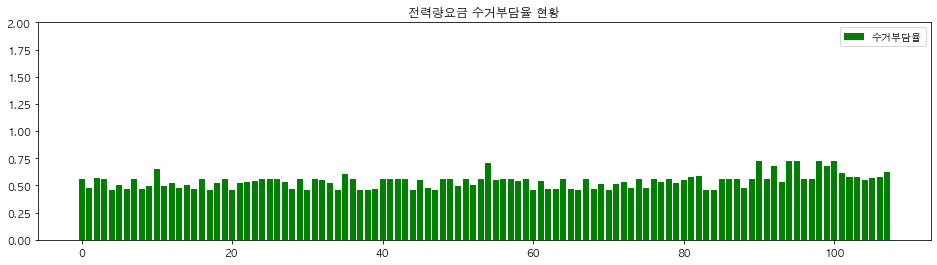

In [60]:
plt.figure(figsize=(16,4))

plt.bar(range(len(col_burden_list)), col_burden_list, color='g', label='수거부담율')
plt.yticks(np.arange(0, 2.1, 0.25))
plt.title("전력량요금 수거부담율 현황")

plt.legend()

plt.show()